# UNET SEMANTIC SEGMENTATION of *Tuta absoluta* on tomato leaves
## UNET from scratch
## Filtred and separated DB

Montar Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalar Pacotes

In [ ]:
pip install tensorflow

In [ ]:
# Install the python version
!apt-get install python3.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.7 is already the newest version (3.7.11-1+bionic1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


Verificar versão python

In [ ]:
!python --version

Python 3.7.11


Importar bibliotecas

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import random
import keras
import tensorflow
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
#from keras.utils import normalize
#from tensorflow.python.keras.utils import normalize
from tensorflow.keras.utils import normalize

Segmentation Models: using `keras` framework.


In [ ]:
print(keras.__version__)
print(tensorflow.__version__)

2.6.0
2.6.0


Parâmetros de entrada

In [ ]:
SIZE_X = 256
SIZE_Y = 256
n_classes=3 #Number of classes for segmentation

#Leitura dos Dados: 

##Imagens de treinamento

In [ ]:
#train_images_names = glob.glob('/content/drive/MyDrive/DB_test_tuta_separated_PS_filtrado/train_2/images/*.png')
train_images_names = glob.glob('/content/drive/MyDrive/DB_tuta_final/train/train_images_patches_filtrado/*.png')
train_images_names.sort()
train_images = [cv2.imread(image,1) for image in train_images_names]
train_images = np.array(train_images)

##Imagens de teste

In [ ]:
test_images_names = glob.glob('/content/drive/MyDrive/DB_test_tuta_separated_PS_filtrado/test_2/256_images/*.png')
#test_images_names = glob.glob('/content/drive/MyDrive/DB_tuta_final/test/test_images_patches_filtrado/*.png')
test_images_names.sort()
test_images = [cv2.imread(image,1) for image in test_images_names]
test_images = np.array(test_images)

#Leitura dos Dados: 
##Máscaras de treinamento

In [ ]:
#train_masks_names = glob.glob('/content/drive/MyDrive/DB_test_tuta_separated_PS_filtrado/train_2/masks/*.png')
train_masks_names = glob.glob('/content/drive/MyDrive/DB_tuta_final/train/train_masks_patches_filtrado/*.png')
train_masks_names.sort()
train_masks = [cv2.imread(mask,0) for mask in train_masks_names]
train_masks = np.array(train_masks)

##Máscaras de teste

In [ ]:
test_masks_names = glob.glob('/content/drive/MyDrive/DB_test_tuta_separated_PS_filtrado/test_2/256_masks/*.png')
#test_masks_names = glob.glob('/content/drive/MyDrive/DB_tuta_final/test/test_masks_patches_filtrado/*.png')
test_masks_names.sort()
test_masks = [cv2.imread(mask,0) for mask in test_masks_names]
test_masks = np.array(test_masks)

Checkpoint legendas máscaras

In [ ]:
print ("Train Image data shape:", train_images.shape)
print ("Test Image data shape:", test_images.shape)
print ("Train Mask data shape:", train_masks.shape)
print ("Train Mask data shape:", test_masks.shape)
print ("Max pixel valeue in train image:", train_images.max())
print ("Max pixel valeue in train image:", test_images.max())
print ("Labels in train masks:", np.unique(train_masks))
print ("Labels in test masks:", np.unique(test_masks))

Train Image data shape: (1628, 256, 256, 3)
Test Image data shape: (200, 256, 256, 3)
Train Mask data shape: (1628, 256, 256)
Train Mask data shape: (200, 256, 256)
Max pixel valeue in train image: 255
Max pixel valeue in train image: 255
Labels in train masks: [ 0 38 75]
Labels in test masks: [ 0 38 75]


#Codificar legendas das máscaras

Máscaras de treinamento

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder() # só funciona em vetor unico e temos 3 dimensoes, com isso faz reshape no vetor
n, h, w = train_masks.shape # separar dimensões do formato da mascara #numero de bandas, altura e largura
train_masks_reshaped = train_masks.reshape(-1,1) # reshape para? (para normalizar)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped) # transformar e adequar, reencoda tudo
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w) # 

np.unique(train_masks_encoded_original_shape) # mostrar legendas das mascaras

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

Máscaras de teste

In [ ]:
labelencoder = LabelEncoder() # só funciona em vetor unico e temos 3 dimensoes, com isso faz reshape no vetor
n, h, w = test_masks.shape # separar dimensões do formato da mascara #numero de bandas, altura e largura
test_masks_reshaped = test_masks.reshape(-1,1) # reshape para? (para normalizar)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped) # transformar e adequar, reencoda tudo
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w) # 

np.unique(test_masks_encoded_original_shape) # mostrar legendas das mascaras

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

##Normalizar lista com imagens e Expandir dimensões das máscaras

Imagens e máscaras treinamento

In [ ]:
from tensorflow.keras.utils import normalize

#train_images = np.expand_dims(train_images, axis=3) # expandir dimensão de uma banda no fim # pulei esta, pois estava perdendo info das bandas
train_images = normalize(train_images, axis=1) # normalizar para que o valor maximo de pixels seja 255

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3) # expandir dimensão das mascaras..
# (256,256) -> (256,256,1) - np.expand_dims(x, axis = -1)

Imagens e máscaras teste

In [ ]:
#train_images = np.expand_dims(train_images, axis=3) # expandir dimensão de uma banda no fim # pulei esta, pois estava perdendo info das bandas
test_images = normalize(test_images, axis=1) # normalizar para que o valor maximo de pixels seja 255

test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3) # expandir dimensão das mascaras..
# (256,256) -> (256,256,1) - np.expand_dims(x, axis = -1)

#Verificar tamanho do DB

In [ ]:
print("Test Images DB Size:", len(test_images))
print("Test Masks DB Size:", len(test_masks_input))
print("Train Images DB Size:", len(train_images))
print("Train Masks DB Size:", len(train_masks_input))

Test Images DB Size: 200
Test Masks DB Size: 200
Train Images DB Size: 1628
Train Masks DB Size: 1628


#Definir X e Y de teste e treinamento

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images,train_masks_input, test_size = 0.10, random_state = 0)

#print("Class values in the dataset are ... ", np.unique(y_train,y_val))  # 0 is the background/few unlabeled 

In [ ]:
print("Training data: ", len(X_train))
print("Testing data: ", len(X_val))

Training data:  1465
Testing data:  163


Categorizar

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)) # rodar também sem esta linha


test_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

In [ ]:
print(y_test_cat.shape)
print(y_train_cat.shape)

Augmentation

In [ ]:
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     #brightness_range=[0.2,0.8],
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     #brightness_range=[0.2,0.8],
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect') 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_val, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train_cat, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train_cat, seed=seed) #y_train
valid_mask_generator = mask_data_generator.flow(y_test_cat, seed=seed) #y_val

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

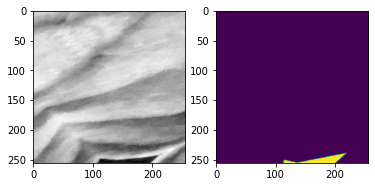

In [ ]:
x = image_generator.next() #.sort()
y = mask_generator.next() #.sort()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

Parâmetros de entrada do modelo

In [ ]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.metrics import Precision
#from keras import backend as K

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def precision_blue(y_true, y_pred):
    precision_blue = precision(y_true, y_pred, 2)
    return precision_blue

def precision_green(y_true, y_pred):
    precision_green = precision(y_true, y_pred, 1)
    return precision_green

def precision_red(y_true, y_pred):
    precision_red = precision(y_true, y_pred, 0)
    return precision_red

def precision_global(y_true, y_pred):
    num_labels = K.int_shape(y_pred)[-1]
    mean_precision = K.variable(0)
    for label in range(num_classes):
        mean_precision = mean_precision + precision(y_true, y_pred, label)
    return mean_precision/num_classes

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def recall_blue(y_true, y_pred):
    recall_blue = recall(y_true, y_pred, 2)
    return recall_blue

def recall_green(y_true, y_pred):
    recall_green = recall(y_true, y_pred, 1)
    return recall_green

def recall_red(y_true, y_pred):
    recall_red = recall(y_true, y_pred, 0)
    return recall_red

def recall_global(y_true, y_pred):
    num_labels = K.int_shape(y_pred)[-1]
    mean_recall = K.variable(0)
    for label in range(num_classes):
        mean_recall = mean_recall + rec(y_true, y_pred, label)
    return mean_recall/num_classes


def f1_score(y_true, y_pred):
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def f1score_blue(y_true, y_pred):
    f1_blue = f1_score(y_true, y_pred, 2)
    return f1_blue

def f1score_green(y_true, y_pred):
    f1_green = f1_score(y_true, y_pred, 1)
    return f1_green

def f1score_red(y_true, y_pred):
    f1_red = f1_score(y_true, y_pred, 0)
    return f1_red

def f1score_global(y_true, y_pred):
    num_labels = K.int_shape(y_pred)[-1]
    f1_global = K.variable(0)
    for label in range(num_classes):
        f1_global = f1_global + f1_score(y_true, y_pred, label)
    return f1_global/num_classes


def iou(y_true, y_pred):
    y_true = K.cast(K.equal(K.argmax(y_true), label), K.floatx())
    y_pred = K.cast(K.equal(K.argmax(y_pred), label), K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return K.switch(K.equal(union, 0), 1.0, intersection / union)

def jaccard_blue(y_true, y_pred):
    iuo_blue = iou(y_true, y_pred, 2)
    return iuo_blue


def jaccard_green(y_true, y_pred):
    iuo_green = iou(y_true, y_pred, 1)
    return iuo_green

def jaccard_red(y_true, y_pred):
    iuo_red = iou(y_true, y_pred, 0)
    return iuo_red

def jaccard_global(y_true, y_pred):
    num_labels = K.int_shape(y_pred)[-1]
    mean_iou = K.variable(0)
    for label in range(num_classes):
        mean_iou = mean_iou + iou(y_true, y_pred, label)
    return mean_iou / num_classes

## Ajustar modelo

Sem augmentação

In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, #50
                    validation_data=(X_val, y_test_cat), #train_masks_cat=
                    #sample_weight=sample_weight, #se balancear classes tem que usar.... não consigo rodar esta célula com esse pesos das classes
                    shuffle=False) #false

Com augmentation

50 épocas

In [ ]:
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=50) # era 50 em tudo..

Epoch 1/50
50/50 [==============================] - 93s 1s/step - loss: 0.9262 - accuracy: 0.5642 - val_loss: 0.8250 - val_accuracy: 0.6007
Epoch 2/50
50/50 [==============================] - 68s 1s/step - loss: 0.7706 - accuracy: 0.6637 - val_loss: 0.7415 - val_accuracy: 0.6809
Epoch 3/50
50/50 [==============================] - 68s 1s/step - loss: 0.7560 - accuracy: 0.6836 - val_loss: 0.7460 - val_accuracy: 0.6728
Epoch 4/50
50/50 [==============================] - 68s 1s/step - loss: 0.7266 - accuracy: 0.6878 - val_loss: 0.7088 - val_accuracy: 0.6923
Epoch 5/50
50/50 [==============================] - 68s 1s/step - loss: 0.6925 - accuracy: 0.7034 - val_loss: 0.6938 - val_accuracy: 0.6948
Epoch 6/50
50/50 [==============================] - 68s 1s/step - loss: 0.7012 - accuracy: 0.6978 - val_loss: 0.7197 - val_accuracy: 0.6859
Epoch 7/50
50/50 [==============================] - 68s 1s/step - loss: 0.6832 - accuracy: 0.7074 - val_loss: 0.6748 - val_accuracy: 0.6953
Epoch 8/50
50/50 [==

100 épocas

In [ ]:
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=100)

Epoch 1/100
91/91 [==============================] - 150s 1s/step - loss: 0.8175 - accuracy: 0.6211 - val_loss: 0.7521 - val_accuracy: 0.6730
Epoch 2/100
91/91 [==============================] - 124s 1s/step - loss: 0.7444 - accuracy: 0.6869 - val_loss: 0.7312 - val_accuracy: 0.6809
Epoch 3/100
91/91 [==============================] - 123s 1s/step - loss: 0.7174 - accuracy: 0.6927 - val_loss: 0.7193 - val_accuracy: 0.6841
Epoch 4/100
91/91 [==============================] - 124s 1s/step - loss: 0.7046 - accuracy: 0.6989 - val_loss: 0.6927 - val_accuracy: 0.7059
Epoch 5/100
91/91 [==============================] - 124s 1s/step - loss: 0.6857 - accuracy: 0.7087 - val_loss: 0.6950 - val_accuracy: 0.6852
Epoch 6/100
91/91 [==============================] - 123s 1s/step - loss: 0.6880 - accuracy: 0.7069 - val_loss: 0.6600 - val_accuracy: 0.7165
Epoch 7/100
91/91 [==============================] - 123s 1s/step - loss: 0.6533 - accuracy: 0.7269 - val_loss: 0.6766 - val_accuracy: 0.6913
Epoch 

150 épocas

In [ ]:
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=150)

Epoch 1/150
91/91 [==============================] - 149s 1s/step - loss: 0.8044 - accuracy: 0.6281 - val_loss: 0.7706 - val_accuracy: 0.6524
Epoch 2/150
91/91 [==============================] - 124s 1s/step - loss: 0.7588 - accuracy: 0.6769 - val_loss: 0.7369 - val_accuracy: 0.6804
Epoch 3/150
91/91 [==============================] - 124s 1s/step - loss: 0.7266 - accuracy: 0.6911 - val_loss: 0.7131 - val_accuracy: 0.6830
Epoch 4/150
91/91 [==============================] - 124s 1s/step - loss: 0.6958 - accuracy: 0.7007 - val_loss: 0.6843 - val_accuracy: 0.6946
Epoch 5/150
91/91 [==============================] - 124s 1s/step - loss: 0.6776 - accuracy: 0.7096 - val_loss: 0.6790 - val_accuracy: 0.6950
Epoch 6/150
91/91 [==============================] - 124s 1s/step - loss: 0.6678 - accuracy: 0.7110 - val_loss: 0.6638 - val_accuracy: 0.6959
Epoch 7/150
91/91 [==============================] - 124s 1s/step - loss: 0.6207 - accuracy: 0.7345 - val_loss: 0.7755 - val_accuracy: 0.4980
Epoch 

Salvar modelo

In [ ]:
model.save('/content/drive/MyDrive/DB_tuta_final/multi_50_epochs_vgg16_s_aug.hdf5')

Salvar resultado para .xml ou .csv

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = '/content/drive/MyDrive/DB_tuta_final/history_multi_50_epochs_vgg16_s_aug.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = '/content/drive/MyDrive/DB_tuta_final/history_multi_50_epochs_vgg16_s_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Ler modelo

In [ ]:
model = get_model() # ler modelo caso esteja qrendo so predizer novamente
model.load_weights('NOME_MODELO.hdf5')   # se houvesse pesos salvos

In [ ]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
model = load_model('/content/drive/MyDrive/DB_tuta_final/history_150_epochs_aug_filtrado_final_1628.hdf5', compile=False)

#Métricas de avaliação

In [ ]:
_, acc = model.evaluate(X_val, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

6/6 [==============================] - 1s 73ms/step - loss: 0.2875 - accuracy: 0.9024
Accuracy is =  90.24022817611694 %


##Plotar Acurácia de treinamento e validação e as perdas em cada época

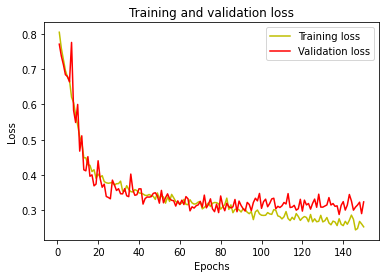

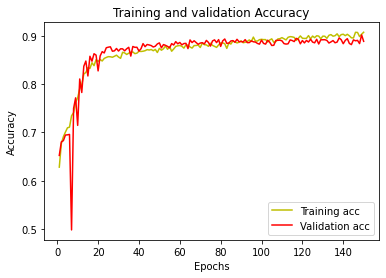

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##IOU

In [ ]:
y_pred=model.predict(X_val)
y_pred_argmax=np.argmax(y_pred, axis=3) #-1

In [ ]:
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_val[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.13445543


##IOU para cada classe

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
print("IoU for class1 is: ", class1_IoU)
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
print("IoU for class2 is: ", class2_IoU)
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])
print("IoU for class3 is: ", class3_IoU)

[[5.457610e+05 3.763146e+06 0.000000e+00]
 [5.110000e+03 5.897341e+06 0.000000e+00]
 [3.450000e+02 4.706210e+05 4.400000e+01]]
IoU for class1 is:  0.12649865
IoU for class2 is:  0.5818088
IoU for class3 is:  9.3416274e-05


##Fazer predição para algumas imagens

(1, 256, 256, 3)
(1, 256, 256, 3)


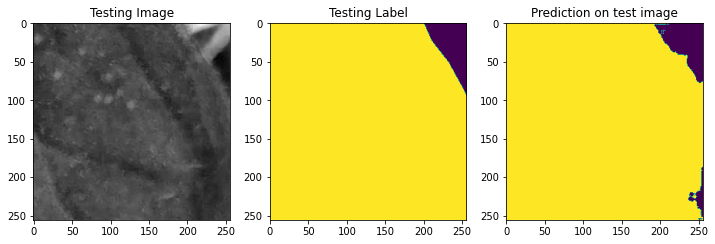

In [ ]:
import random

test_img_number = random.randint(0, len(X_val))
test_img = X_val[test_img_number]
#test_img = (test_img, cv2.COLOR_BGR2RGB)
ground_truth=y_val[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None] #pode tirar essa tb
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input))
print(prediction.shape)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray') #viridis
#plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
#plt.imshow(ground_truth)
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
#plt.imshow(predicted_img, cmap='gray')
plt.show()